In [1]:
import importlib
import tensorflow as tf
from keras.applications import InceptionV3

from Faz1_MultiLabel_File_Dataset import utils
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot as plt
importlib.reload(utils)

ORIGINAL_DATA_PATH = "datasets/CSV_Multi_Label_Classification"
AUGMENTED_DATA_PATH = "datasets/CSV_Multi_Label_Classification_Augmented"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
tf.test.is_built_with_cuda()

True

In [2]:
print("TensorFlow version:", tf.__version__)
print("GPU Build Info:", tf.sysconfig.get_build_info())
print("GPU Devices:", tf.config.list_physical_devices('GPU'))

# Bellek optimizasyonu (GPU kullanımı için)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)#TensorFlow’un başlangıçta minimum bellek tahsis etmesini ve yalnızca gerektiğinde bellek kullanmasını sağlar.
    except RuntimeError as e:
        print(e)


TensorFlow version: 2.10.1
GPU Build Info: OrderedDict([('cpu_compiler', 'C:/Program Files (x86)/Microsoft Visual Studio/2019/Community/VC/Tools/MSVC/14.29.30133/bin/HostX64/x64/cl.exe'), ('cuda_compute_capabilities', ['sm_35', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'compute_80']), ('cuda_version', '64_112'), ('cudart_dll_name', 'cudart64_112.dll'), ('cudnn_dll_name', 'cudnn64_8.dll'), ('cudnn_version', '64_8'), ('is_cuda_build', True), ('is_rocm_build', False), ('is_tensorrt_build', False), ('msvcp_dll_names', 'msvcp140.dll,msvcp140_1.dll'), ('nvcuda_dll_name', 'nvcuda.dll')])
GPU Devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [11]:
#dataset-load
train_df = utils.load_data("train", AUGMENTED_DATA_PATH)
test_df = utils.load_data("test", ORIGINAL_DATA_PATH)
valid_df = utils.load_data("valid", ORIGINAL_DATA_PATH)
#tensor dataset transform
augmented_train_dataset = utils.create_dataset(train_df)
valid_dataset = utils.create_dataset(valid_df)
test_dataset = utils.create_dataset(test_df)

In [4]:
base_model = InceptionV3(
    include_top=False, # Son katmanı at
    weights="imagenet", # ImageNet ağırlıklarını getir
    input_shape=(224, 224, 3)
)

base_model.trainable = False

inputs = tf.keras.Input(shape=(224, 224, 3))

x = base_model(inputs, training=False)

x = GlobalAveragePooling2D()(x)

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x) # Stabilizasyon
x = Dropout(0.5)(x) # Overfitting önleyici

outputs = Dense(3, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 batch_normalization_94 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 dropout (Dropout)           (None, 256)               0     

In [5]:
# 1. Compile
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

my_callbacks= [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',#Doğrulama kaybını izle
        patience=10,#x epoch boyunca iyileşme olmazsa dur
        restore_best_weights=True# En iyi ağırlıklara geri dön
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',# Doğrulama kaybı durursa
        factor=0.2,# Öğrenme oranını %x azalt
        patience=3,# x epoch boyunca iyileşme olmazsa lr düşür
        min_lr=1e-6 # En düşük learningrate oranı
    )
]

In [6]:
history = model.fit(
    augmented_train_dataset,
    validation_data=valid_dataset,
    epochs=50,
    callbacks=my_callbacks,
    verbose=1
)

Epoch 1/50
635/635 [==============================] - 88s 120ms/step - loss: 0.7474 - accuracy: 0.7069 - val_loss: 0.6230 - val_accuracy: 0.7779 - lr: 0.0010
Epoch 2/50
635/635 [==============================] - 72s 113ms/step - loss: 0.5445 - accuracy: 0.7870 - val_loss: 0.5430 - val_accuracy: 0.8088 - lr: 0.0010
Epoch 3/50
635/635 [==============================] - 72s 113ms/step - loss: 0.5024 - accuracy: 0.8053 - val_loss: 0.5423 - val_accuracy: 0.8118 - lr: 0.0010
Epoch 4/50
635/635 [==============================] - 72s 114ms/step - loss: 0.4826 - accuracy: 0.8149 - val_loss: 0.5571 - val_accuracy: 0.8068 - lr: 0.0010
Epoch 5/50
635/635 [==============================] - 73s 114ms/step - loss: 0.4622 - accuracy: 0.8276 - val_loss: 0.6602 - val_accuracy: 0.7928 - lr: 0.0010
Epoch 6/50
635/635 [==============================] - 143s 225ms/step - loss: 0.4481 - accuracy: 0.8320 - val_loss: 0.5353 - val_accuracy: 0.8307 - lr: 0.0010
Epoch 7/50
635/635 [==============================]

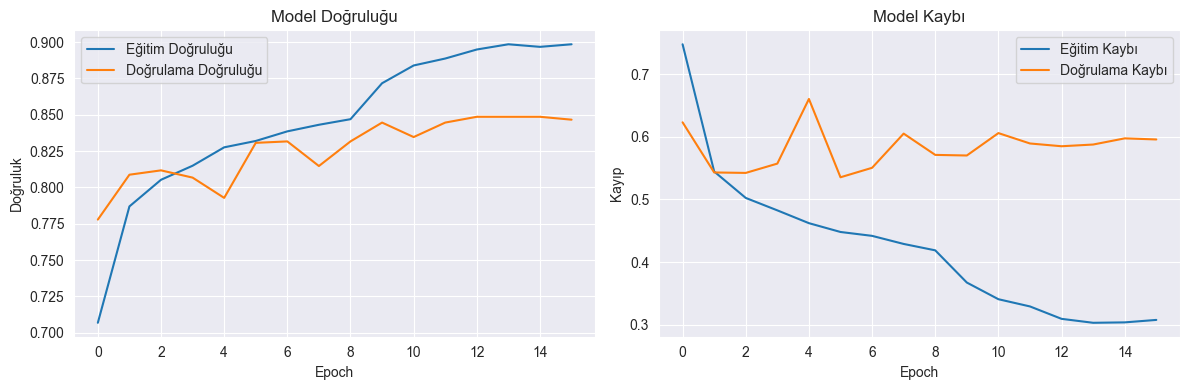

In [9]:
# Eğitim sonuçlarını görselleştir
plt.figure(figsize=(12, 4))#12X4 LÜK GRAFİK PENCERESİ OLUŞTUR.

#Accuracy Greafiği
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Model Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()

#Loss grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Model Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()

plt.tight_layout()
plt.show()

Accuracy: 0.8567
F1 Score: 0.8613
ROC-AUC Score: 0.9553


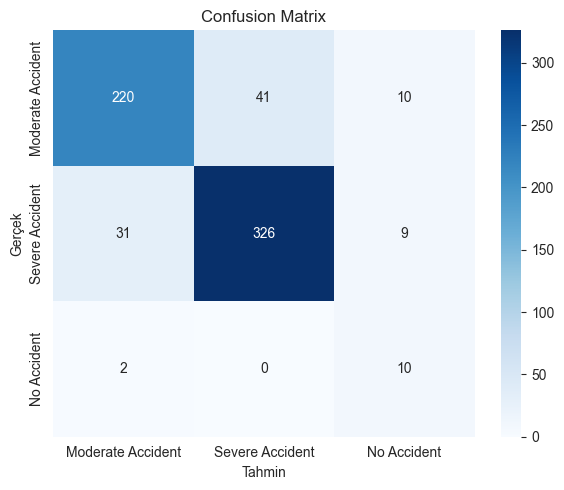


Sınıf Bazlı Performans:
                   precision    recall  f1-score   support

Moderate Accident       0.87      0.81      0.84       271
  Severe Accident       0.89      0.89      0.89       366
      No Accident       0.34      0.83      0.49        12

         accuracy                           0.86       649
        macro avg       0.70      0.85      0.74       649
     weighted avg       0.87      0.86      0.86       649



In [12]:
class_names = ['Moderate Accident', 'Severe Accident', 'No Accident']
utils.evaluate_model(model, test_dataset, class_names)